In [10]:
##ML / nerd shit import
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Rael import
import datetime
import os
import urllib
import json
import yfinance as yf

In [225]:
#### READ THIS BEFORE CONTINUING ####

### CHANGE THE FOLLOWING VARIABLES ###
stock_name = "SPY" #--> GIVE THE TICKER NAME


### START AND END_DATES, GIVE YYYY-MM-DD format
start_date = "2023-05-29"

end_date = "2023-06-02"

### CHOOSE INTERVAL OF TRAINING DATA, BEWARNED THAT IF YOUR START AND END, LONG, MIGHT NOT BE ABLE TO GET LARGE INTERVAL 

time_interval = "1m" ## LIST OF HISTORY: [“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”]


In [226]:
#for saving / upadting / testing?
#need to change, then can run the above!
curr_day_to_string = datetime.date.today()
cache_fname = "/historical/" + f"{stock_name}_{curr_day_to_string}.csv"

stock = yf.Ticker(stock_name)
## TO change the historical values, try to stick to 1m granularity
data = pd.DataFrame(stock.history(start=start_date, end=end_date, interval=time_interval))
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Datetime,,,,,,,,
2023-05-30 09:30:00-04:00,422.029999,422.320007,422.000000,422.320007,1973663,0.0,0.0,0.0
2023-05-30 09:31:00-04:00,422.329987,422.390015,421.910004,421.929993,402094,0.0,0.0,0.0
2023-05-30 09:32:00-04:00,421.929993,422.410004,421.929993,422.370087,343951,0.0,0.0,0.0
2023-05-30 09:33:00-04:00,422.380005,422.540100,422.230011,422.510010,406056,0.0,0.0,0.0
2023-05-30 09:34:00-04:00,422.500000,422.579987,422.355011,422.399994,303225,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-06-01 15:55:00-04:00,421.410004,421.649994,421.410004,421.605011,494623,0.0,0.0,0.0
2023-06-01 15:56:00-04:00,421.609985,421.640015,421.429993,421.450012,536649,0.0,0.0,0.0
2023-06-01 15:57:00-04:00,421.459991,421.515015,421.355011,421.445007,396736,0.0,0.0,0.0


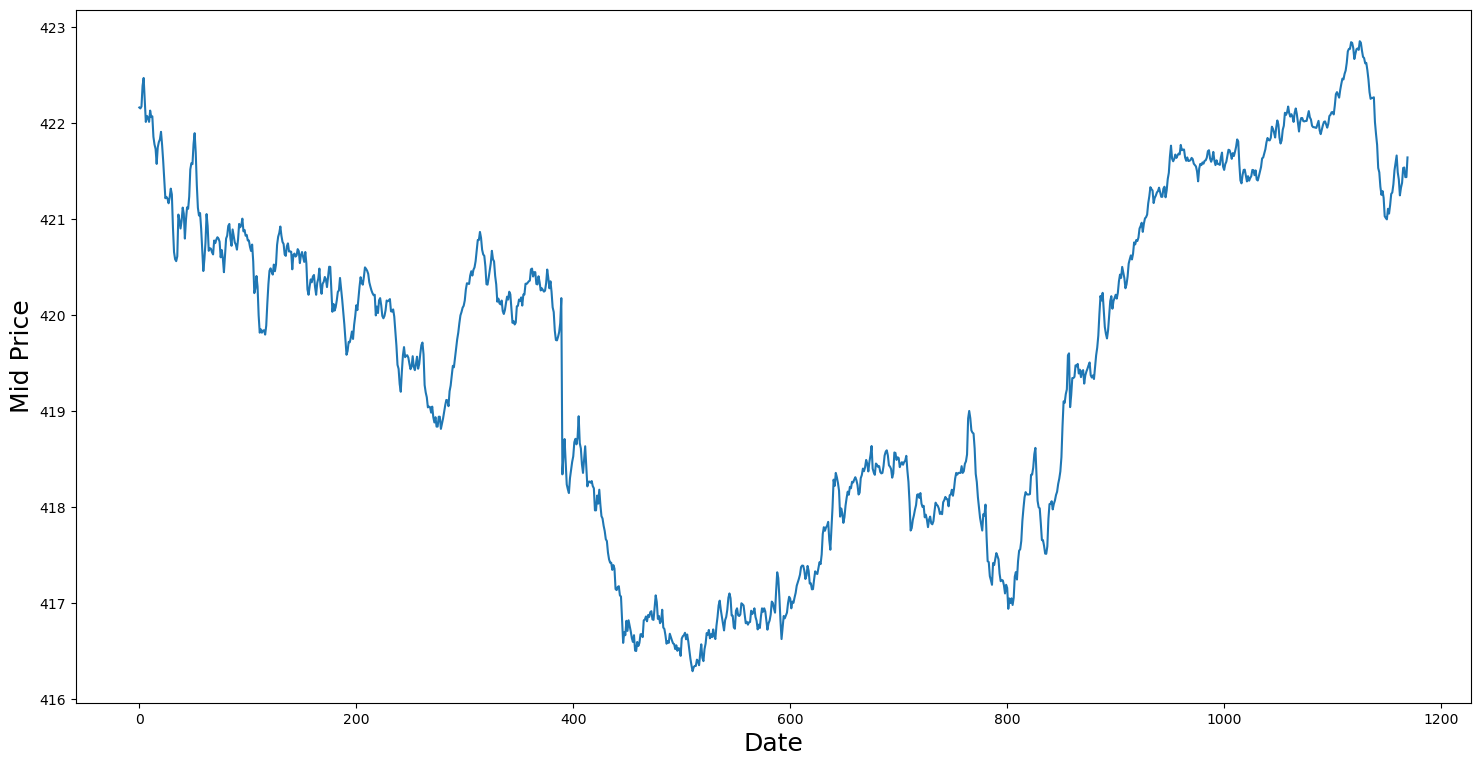

In [227]:



## NO CHANGES FROM HERE, JUST RUN EVERYTHING SEE NICE GRAPH


df = data.copy()
#df = df.rename(columns={'Datetime': 'Date'})
#visualization
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0) #we take an average
#plt.xticks(range(0,df.shape[0],500),df['Datetime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [228]:
#let's try to predict the last 10% of values (this is arbitrary)
#default [1:3] = high + low
length = len(df)
train_len = math.ceil(0.9 * length)
print(train_len)
training_set = df.iloc[:train_len, 1:2].values
#print(training_set)
test_set = df.iloc[train_len:, 1:2].values #take the last x values? (to predict!)
print(test_set.shape)

1053
(117, 1)


In [229]:
# Input features: time lag of 60 time steps
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1)) #-->every scaled btwn 0-1, helps with variance
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, train_len-60):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(933, 60, 1)


In [230]:
##TODO: Maybe tune the model such that LSTM units are changed?
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 256)

Epoch 1/100
4/4 [==============================] - 5s 199ms/step - loss: 0.1746
Epoch 2/100
4/4 [==============================] - 1s 204ms/step - loss: 0.0378
Epoch 3/100
4/4 [==============================] - 1s 207ms/step - loss: 0.0216
Epoch 4/100
4/4 [==============================] - 1s 206ms/step - loss: 0.0290
Epoch 5/100
4/4 [==============================] - 1s 205ms/step - loss: 0.0157
Epoch 6/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0169
Epoch 7/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0121
Epoch 8/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0116
Epoch 9/100
4/4 [==============================] - 1s 204ms/step - loss: 0.0093
Epoch 10/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0087
Epoch 11/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0086
Epoch 12/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0079
Epoch 13/100
4/4 [===================

In [231]:
dataset_train = df.iloc[:train_len, 1:2]
dataset_test = df.iloc[train_len:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


print(dataset_total.shape)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, train_len):
    temp = inputs[i-60:i, 0:1]
    if (len(temp) != 60):
        break
    X_test.append(temp)
X_test = np.array(X_test, dtype=np.float32)
print(X_test.shape)
X_test = X_test.reshape((X_test.shape[0], -1))
#reshape into 3D model for LSTM 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

(1170, 1)
(177, 1)
(118, 60, 1)


In [232]:
#x_train = np.array([tf.cast(val, dtype=object) for val in X_test])
#x_train = tf.cast(x_train , dtype=tf.float32)
print(X_test)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

[[[0.8504688 ]
  [0.84726983]
  [0.8440513 ]
  ...
  [0.9236374 ]
  [0.8922857 ]
  [0.88103056]]

 [[0.84726983]
  [0.8440513 ]
  [0.8424469 ]
  ...
  [0.8922857 ]
  [0.88103056]
  [0.89067644]]

 [[0.8440513 ]
  [0.8424469 ]
  [0.8569158 ]
  ...
  [0.88103056]
  [0.89067644]
  [0.8995177 ]]

 ...

 [[0.9807082 ]
  [0.9871404 ]
  [0.98955435]
  ...
  [0.85048354]
  [0.84887916]
  [0.8287827 ]]

 [[0.9871404 ]
  [0.98955435]
  [0.99517703]
  ...
  [0.84887916]
  [0.8287827 ]
  [0.8279584 ]]

 [[0.98955435]
  [0.99517703]
  [1.0032185 ]
  ...
  [0.8287827 ]
  [0.8279584 ]
  [0.88103056]]]
4/4 [==============================] - 1s 15ms/step


(118, 1)


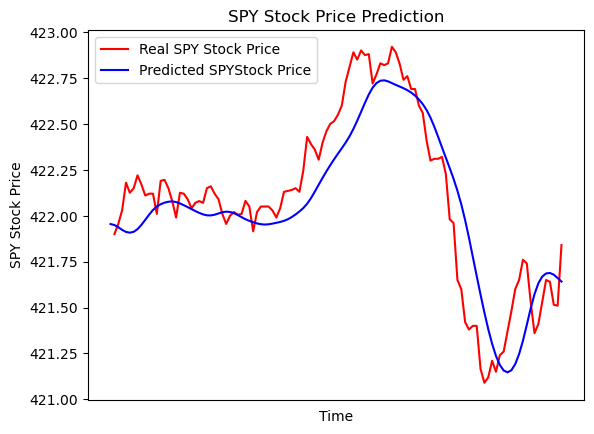

In [233]:
## to check prediction 
df =df.reset_index() #--> get rid of datetime as default index
plt.plot(df.loc[train_len:, "Datetime"],dataset_test.values, color = "red", label = f'Real {stock_name} Stock Price')
print(predicted_stock_price.shape)
plt.plot(df.loc[train_len - 1:, "Datetime"],predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
plt.xticks(np.arange(118,1)) #this is just to clear the x-axis
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_name} Stock Price')
plt.legend()
plt.show()

In [189]:
print(predicted_stock_price)

[[419.4409 ]
 [419.4442 ]
 [419.4492 ]
 [419.45547]
 [419.46265]
 [419.46902]
 [419.47308]
 [419.4749 ]
 [419.47443]
 [419.4723 ]
 [419.46774]
 [419.46027]
 [419.45093]
 [419.4399 ]
 [419.4277 ]
 [419.41458]
 [419.40137]
 [419.3906 ]
 [419.38403]
 [419.384  ]
 [419.39105]
 [419.40445]
 [419.42325]
 [419.44638]
 [419.47202]
 [419.49777]
 [419.52176]
 [419.5425 ]
 [419.5593 ]
 [419.5721 ]
 [419.58102]
 [419.58582]
 [419.58597]
 [419.57996]
 [419.56628]
 [419.54187]
 [419.50717]
 [419.46643]
 [419.42386]
 [419.38333]
 [419.34814]
 [419.31998]
 [419.29843]
 [419.28165]
 [419.26785]
 [419.25693]
 [419.2494 ]
 [419.24503]
 [419.24414]
 [419.24805]
 [419.25784]
 [419.27274]
 [419.29077]
 [419.30872]
 [419.3228 ]
 [419.33102]
 [419.33368]
 [419.33008]
 [419.31906]
 [419.29974]
 [419.27176]
 [419.23605]
 [419.194  ]
 [419.1485 ]
 [419.1027 ]
 [419.0605 ]
 [419.0262 ]
 [419.00238]
 [418.98993]
 [418.98898]
 [418.997  ]
 [419.0106 ]
 [419.02704]
 [419.0454 ]
 [419.06534]
 [419.08734]
 [419.1112 ]